# Projeto de NLP 

## Definição e escopo do problema

**IMDb**, também conhecida como *Internet Movie Database*, é uma base de dados online de informação sobre cinema, TV, música e games, hoje pertencente à Amazon. 

O dataset IMDB, contém críticas de filmes e se a resenha foi positiva ou negativa.

Portanto, iremos analisar essa base de dados e **interpretar os textos** para realizar uma **análise de sentimentos**.

## Coleta de dados
A base de dados utilizada pode ser acessada [aqui](https://www.kaggle.com/luisfredgs/imdb-ptbr).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.1 MB/s 


In [3]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import nltk
from nltk import tokenize
from nltk import corpus
nltk.download('stopwords')
from string import punctuation
import seaborn as sns
import unidecode

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
resenha = pd.read_csv('/content/drive/MyDrive/PLN/imdb-reviews-pt-br.csv')

In [8]:
resenha.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


**text_en:** a resenha em inglês. 

**text_pt:** a resenha traduzida para português.

**sentiment:** se a resenha é positiva ou negativa. 

In [9]:
resenha.shape

(49459, 4)

In [10]:
resenha.isnull().sum()

id           0
text_en      0
text_pt      0
sentiment    0
dtype: int64

In [11]:
resenha.sentiment.value_counts()

neg    24765
pos    24694
Name: sentiment, dtype: int64

Como podemos ver acima, a base de dados possui quase 50 mil linhas, ou seja, temos 50 mil resenhas. Sendo 24.765 resenhas negativas e 24.694 resenhas positivas. 
Agora vamos dar uma olhada em uma resenha negativa e em uma positiva, para conhecer a escrita, se é informal ou formal, se possui números. Tudo isso pode ser importante mais para frente.

In [12]:
print("Negativa \n")
print(resenha.text_pt[189])

Negativa 

Este é sem dúvida o pior filme que eu já vi. E acredite em mim, eu vi muitos filmes. A reviravolta inacreditável que o filme faz - passando de um extremamente mau filme "Formas de vida alienígenas habitam a terra", com um filme que tenta espalhar um arquicristiano "O dia do julgamento está próximo, buscar Jesus ou queimar por toda a eternidade em as dívidas ardentes do inferno "mensagem - deixou-me atordoado depois de ter sido atormentado por 85 minutos. Até mesmo os cristãos religiosos devem se envergonhar ou ficar furiosos ao ver suas crenças postadas dessa maneira. Eu não sabia o que fazer comigo quando assisti a atuação horrível que poderia ter sido realizada por crianças de 7 anos de idade. Simplesmente repugnante. Eu não sou cristão nem muito religioso. Mas se eu estivesse, não teria mais medo do Inferno. Rich Christiano mostrou ser algo muito pior.


In [13]:
print("Positivo \n")
print(resenha.text_pt[49002])

Positivo 

Crescendo em Nova York no final dos anos 80 e início dos anos 90, posso dizer pessoalmente que este é um dos documentários mais importantes feitos para cobrir esse lugar neste período de tempo. Não Madonna não veio com a idéia de Voguing, mas é de onde ela tirou! Em vez de combater a violência uns dos outros ou em brigas de gato, o voguing permitia que as pessoas "lutassem" dentro dos confins de tudo, menos que tocassem umas às outras, o que justificaria uma desqualificação automática. Vendo este tipo de extraordinariamente talentosas / bem orquestradas "jogadas" nos clubes foi nada menos do que espetacular e todos os grandes nomes de antigamente estão aqui ... Pepper La Beija, Paris Duprée, Xtragavaganza, etc. ..tudo comemorado nos gostos de peças de época como a música de Malcom McLarens "Deep in Vogue" ... não importava quem você era, ou de onde você era porque quando você passava por aquelas portas nesse "reino mágico" de De certa forma, você se tornou parte de algo maio

Agora vamos classificar os filmes positivos como 1 e os negativos como 0. E criar uma coluna nova com essa classificação.

In [14]:
classificacao = resenha["sentiment"].replace(["neg", "pos"], [0,1])

In [15]:
resenha['classificacao'] = classificacao

In [16]:
resenha.head()

,id,text_en,text_pt,sentiment,classificacao
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


## Removendo Stopwords e tratamento dos dados 

### Stopwords
Stopwords são palavras que podem ser consideradas irrelevantes para um certo
resultado buscado, portanto iremos eliminar as stopwords da nossa coluna de resenha.

In [17]:
token_espaco = tokenize.WhitespaceTokenizer()
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")
frase_processada = list()

for opiniao in resenha["text_pt"]:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in palavras_irrelevantes:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
resenha["texto_sem_stopwords"] = frase_processada

### Pontuação
Iremos remover todas as pontuações da coluna de resenhas. 

In [18]:
token_pontuacao = tokenize.WordPunctTokenizer()

pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

pontuacao_stopwords = pontuacao + palavras_irrelevantes

frase_processada = list()
for opiniao in resenha["texto_sem_stopwords"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

resenha["texto_sem_pontuacao"] = frase_processada

### Acentos
Iremos remover todos os acentos das palavras na coluna de resenhas. 

In [19]:
sem_acentos = [unidecode.unidecode(texto) for texto in resenha["texto_sem_pontuacao"]]
stopwords_sem_acento = [unidecode.unidecode(texto) for texto in pontuacao_stopwords]

In [20]:
resenha["texto_sem_acento"] = sem_acentos

frase_processada = list()
for opiniao in resenha["texto_sem_acento"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
resenha["texto_sem_acento"] = frase_processada

### Tranformando todo o texto em letras minúsculas
Os tokens em maiúsculo e minúsculo são considerados diferentes, por isso iremos transformar todo o texto para letras minúsculas.

In [21]:
frase_processada = list()
for opiniao in resenha["texto_sem_acento"]:
    nova_frase = list()
    opiniao = opiniao.lower()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
resenha["texto_tratado"] = frase_processada

In [22]:
resenha.head()

,id,text_en,text_pt,sentiment,classificacao,texto_sem_stopwords,texto_sem_pontuacao,texto_sem_acento,texto_tratado
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...,Mais vez Sr Costner arrumou filme tempo necess...,vez sr costner arrumou filme tempo necessario ...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes acao mesmos...,exemplo motivo maioria filmes acao mesmos gene...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...,Primeiro tudo odeio raps imbecis poderiam agir...,primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever musicas todos gos...,beatles puderam escrever musicas todos gostass...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...,Filmes fotos latao palavra apropriada verdade ...,filmes fotos latao palavra apropriada verdade ...


### Bag of Words
Vamos implantar o Bag of words (saco de palavras). 
BoW é uma forma de representar o texto de acordo com a ocorrência das palavras nele, vetorizando esse texto. 


In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vetorizar = CountVectorizer(lowercase=False, max_features=50)
bag_of_words = vetorizar.fit_transform(resenha.texto_tratado)
print(bag_of_words.shape)

(49459, 50)


No primeiro momento não foi passado o max_features para o CountVectorizer(), o que gerou um vetor com 156923 colunas, o que custaria muito armazenamento de memória e tempo de processamento, por isso foi definido o max_features como 50. Assim, o vetor possui o tamanho que desejamos, mostrando as palavras que mais aparecem nas resenhas. 

In [24]:
matriz_esparsa =  pd.DataFrame.sparse.from_spmatrix(bag_of_words, 
                                            columns=vetorizar.get_feature_names_out())

In [28]:
matriz_esparsa.head()

,acho,ainda,algumas,alguns,anos,apenas,assistir,bem,bom,cenas,...,tempo,ter,the,todo,todos,tudo,ver,vez,vi,vida
0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
1,0,1,0,0,0,0,3,2,0,0,...,0,0,0,0,1,0,4,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,2,0,1,0,0
3,0,1,0,0,1,1,0,1,0,0,...,1,1,0,1,2,0,1,0,1,0
4,0,0,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
todas_palavras = ''.join([texto for texto in resenha.texto_tratado])

In [30]:
len(todas_palavras)

44570839

In [31]:
nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, 
                           collocations=False).generate(todas_palavras)

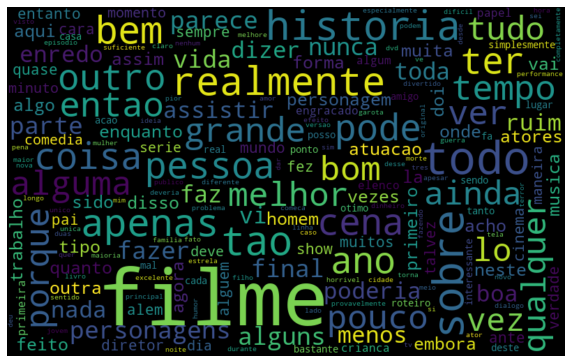

In [32]:
plt.figure(figsize=(10,7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.show()

Segregando a visualização entre positiva e negativa

In [33]:
def nuvem_palavras_pos_neg(texto, coluna_texto, query):
  texto_pos_neg = texto.query(query)
  todas_palavras = ' '.join([texto for texto in texto_pos_neg[coluna_texto]])

  nuvem_palavras = WordCloud(width=800, height=500, 
                             max_font_size=110, 
                           collocations=False).generate(todas_palavras)
  plt.figure(figsize=(10,7))
  plt.imshow(nuvem_palavras, interpolation='bilinear')
  plt.axis('off')
  plt.show()

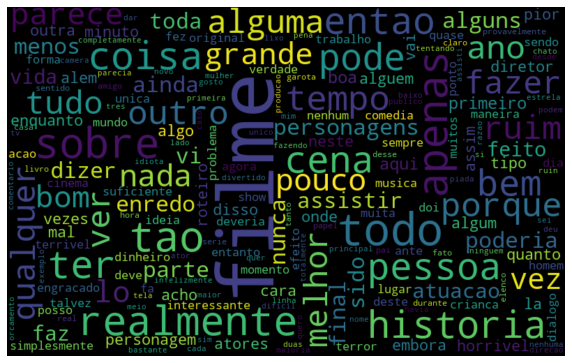

In [34]:
nuvem_palavras_neg = nuvem_palavras_pos_neg(resenha, "texto_tratado", "sentiment == 'neg'")
nuvem_palavras_neg

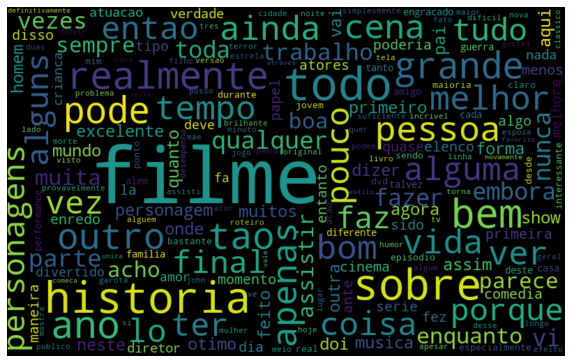

In [35]:
nuvem_palavras_pos = nuvem_palavras_pos_neg(resenha, "texto_tratado", "sentiment == 'pos'")

## Tokenização

A tokenização é o processo de receber um texto e separar suas palavras de acordo com um tipo de separação específica, gerando os chamados tokens, que são as partes segregadas daquele texto.

**Tokenizar = separar as palavras do texto**

In [36]:
token_espaco = tokenize.WhitespaceTokenizer()
token_resenhas = token_espaco.tokenize(todas_palavras)

In [37]:
frequencia = nltk.FreqDist(token_resenhas)

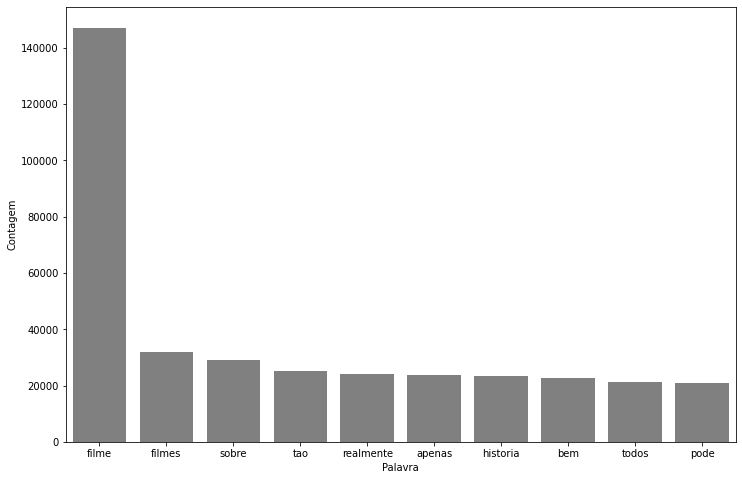

In [38]:
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                              "Frequência": list(frequencia.values())})
df_frequencia = df_frequencia.nlargest(columns= "Frequência", n= 10)
plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_frequencia, x= "Palavra", y = "Frequência", color = 'gray')
ax.set(ylabel = "Contagem")
plt.show()  

Olhando esse gráfico é possível observar que algumas palavras são muito parecidas, como filme e seu plural filmes. Para isso, pode ser feita algumas técnicas como .....

## Previsão

Vamos abaixo segregar os dados em treino e teste e aplicar Regressão Logística para prever se o modelo consegue prever se as resenhas são positivas ou negativas. 

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=False, max_features=50)
tfidf_texto = tfidf.fit_transform(resenha["texto_tratado"])
treino, teste, classe_treino, classe_teste = train_test_split(tfidf_texto,
                                                              resenha["classificacao"],
                                                              random_state = 42)
regressao_logistica = LogisticRegression(solver="lbfgs")
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf)

0.6871815608572583
